<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/15_protein_ligand_docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nglview redo

  Created wheel for nglview: filename=nglview-3.0.6-py3-none-any.whl size=10096109 sha256=e4999d21943fde78cdeb37240c8ac9185ea95973cca55f2b5415b4853852d9ba
  Stored in directory: /root/.cache/pip/wheels/48/56/11/f23486e3ce7371bd7e216b0e1643057a435ecfc413666020a4
Successfully built nglview


In [ ]:
#!apt install libopenbabel-dev

In [ ]:
pip install git+https://github.com/volkamerlab/opencadd

In [ ]:
pip install mdanalysis

In [ ]:
#Installing py3Dmol using pip
!pip install py3Dmol rdkit
#Installing biopython using pip
!pip install biopython
#Installing pdb2pqr v3.0 using pip
!pip install pdb2pqr
#We will also install kora for using RDkit
!pip install kora

In [ ]:
#Install conda using the new conda-colab library
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

#Install MGLtools and OpenBabel from
#the bioconda repository
!conda update -n base -c defaults conda
!conda install -c conda-forge -c bioconda mgltools openbabel zlib --yes

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py310_23.3.1-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [ ]:
#Download and extract Autodock Vina from SCRIPPS
#Then, we set up an alias for vina to be treated as a native binary
%%bash
wget https://vina.scripps.edu/wp-content/uploads/sites/55/2020/12/autodock_vina_1_1_2_linux_x86.tgz
tar xzvf autodock_vina_1_1_2_linux_x86.tgz

In [ ]:
%alias vina /content/autodock_vina_1_1_2_linux_x86/bin/vina
%alias vina_split /content/autodock_vina_1_1_2_linux_x86/bin/vina_split

In [ ]:
# import libraries
import warnings
from pathlib import Path
import subprocess
import py3Dmol

import nglview as nv
from openbabel import pybel

from opencadd.structure.core import Structure

In [ ]:
# retrieve structure from the Protein Data Bank
pdb_id = "2ito"
structure = Structure.from_pdbid(pdb_id)
# element information maybe missing, but important for subsequent PDBQT conversion
if not hasattr(structure.atoms, "elements"):
    structure.add_TopologyAttr("elements", structure.atoms.types)
structure
# NBVAL_CHECK_OUTPUT

<Universe with 2484 atoms>

In [ ]:
# write the protein file to disk
protein = structure.select_atoms("protein")
protein.write("protein.pdb")

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'record_types' Using default value of 'ATOM'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1198: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [ ]:
def pdb_to_pdbqt(pdb_path, pdbqt_path, pH=7.4):
    """
    Convert a PDB file to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    pdb_path: str or pathlib.Path
        Path to input PDB file.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = list(pybel.readfile("pdb", str(pdb_path)))[0]
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    return

In [ ]:
# convert protein to PDBQT format
pdb_to_pdbqt("protein.pdb", "protein.pdbqt")

In [ ]:
# define ligand SMILES for protein-ligand complex of interest
smiles = "COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4"

In [ ]:
! apt-get install pymol

In [ ]:
#!wget -O 1OYT.pdb https://files.rcsb.org/download/1oyt.pdb
com_file = open('fetch_and_clean.pml','w')
com_file.write('''
load protein.pdb
remove resn HOH
h_add elem O or elem N
select 1OYT-FSN, resn FSN #Create a selection called 1OYT-FSN from the ligand
select 1OYT-receptor, 1OYT and not 1OYT-FSN #Select all that is not the ligand
save 1OYT-FSN.pdb, 1OYT-FSN
save 1OYT-receptor.pdb, 1OYT-receptor
''')
com_file.close()

In [ ]:
!pymol -c fetch_and_clean.pml

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 2 CPU cores.  Enabled multithreaded rendering.
PyMOL>load protein.pdb
TITLE     MDANALYSIS FRAME 0: Created by PDBWriter
 ObjectMolecule: Read crystal symmetry information.
 CmdLoad: "" loaded as "protein".
PyMOL>remove resn HOH
PyMOL>h_add elem 

In [ ]:
!obabel 1OYT-receptor.pdb -xr -O 1OYT-receptor.pdbqt
!obabel 1OYT-FSN.pdb -O 1OYT-FSN.pdbqt

In [ ]:
def smiles_to_pdbqt(smiles, pdbqt_path, pH=7.4):
    """
    Convert a SMILES string to a PDBQT file needed by docking programs of the AutoDock family.

    Parameters
    ----------
    smiles: str
        SMILES string.
    pdbqt_path: str or pathlib.path
        Path to output PDBQT file.
    pH: float
        Protonation at given pH.
    """
    molecule = pybel.readstring("smi", smiles)
    # add hydrogens at given pH
    molecule.OBMol.CorrectForPH(pH)
    molecule.addh()
    # generate 3D coordinates
    molecule.make3D(forcefield="mmff94s", steps=10000)
    # add partial charges to each atom
    for atom in molecule.atoms:
        atom.OBAtom.GetPartialCharge()
    molecule.write("pdbqt", str(pdbqt_path), overwrite=True)
    return

In [ ]:
# convert the ligand into PDBQT format
smiles_to_pdbqt(smiles, "ligand.pdbqt")

In [ ]:
ligand_resname = "IRE"
ligand = structure.select_atoms(f"resname {ligand_resname}")
pocket_center = (ligand.positions.max(axis=0) + ligand.positions.min(axis=0)) / 2
pocket_size = ligand.positions.max(axis=0) - ligand.positions.min(axis=0) + 5

In [ ]:
def run_smina(
    ligand_path, protein_path, out_path, pocket_center, pocket_size, num_poses=10, exhaustiveness=8
):
    """
    Perform docking with Smina.

    Parameters
    ----------
    ligand_path: str or pathlib.Path
        Path to ligand PDBQT file that should be docked.
    protein_path: str or pathlib.Path
        Path to protein PDBQT file that should be docked to.
    out_path: str or pathlib.Path
        Path to which docking poses should be saved, SDF or PDB format.
    pocket_center: iterable of float or int
        Coordinates defining the center of the binding site.
    pocket_size: iterable of float or int
        Lengths of edges defining the binding site.
    num_poses: int
        Maximum number of poses to generate.
    exhaustiveness: int
        Accuracy of docking calculations.

    Returns
    -------
    output_text: str
        The output of the Smina calculation.
    """
    output_text = subprocess.check_output(
        [
            "smina",
            "--ligand",
            str(ligand_path),
            "--receptor",
            str(protein_path),
            "--out",
            str(out_path),
            "--center_x",
            str(pocket_center[0]),
            "--center_y",
            str(pocket_center[1]),
            "--center_z",
            str(pocket_center[2]),
            "--size_x",
            str(pocket_size[0]),
            "--size_y",
            str(pocket_size[1]),
            "--size_z",
            str(pocket_size[2]),
            "--num_modes",
            str(num_poses),
            "--exhaustiveness",
            str(exhaustiveness),
        ],
        universal_newlines=True,  # needed to capture output text
    )
    return output_text

In [ ]:
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static

In [ ]:
!chmod u+x smina.static

In [ ]:
!./smina.static

Missing receptor.

Correct usage:

Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimen

alternative

In [ ]:
#Downloading the PDB files using biopython
import os
from Bio.PDB import *
pdbid = ['1hsg']
pdbl = PDBList()
for s in pdbid:
  pdbl.retrieve_pdb_file(s, pdir='.', file_format ="pdb", overwrite=True)
  os.rename("pdb"+s+".ent", s+".pdb")

In [ ]:
#This script will create a folder called "single-docking" for our experiment
#Then, it will print all "ATOM" and "TER" lines from a given PDB into a new file

#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path

#Then, we define the path of the folder we want to create.
#Notice that the HOME folder for a hosted runtime in colab is /content/
singlepath = Path("/content/single-dock/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(singlepath):
  print("path already exists")
if not os.path.exists(singlepath):
  os.mkdir(singlepath)
  print("path was succesfully created")

#Now we assign a variable "protein" with the name and extension of our pdb
protein = "1hsg.pdb"

#And we use the following script to selectively print the lines that contain the
#string "ATOM" and "TER" into a new file inside our recently created folder
with open(singlepath / "1hsg_prot.pdb","w") as g:
  f = open(protein,'r')
  for line in f:
    row = line.split()
    if row[0] == "ATOM":
      g.write(line)
    elif row[0] == "TER":
      g.write("TER\n")
  g.write("END")
  print("file successfully created")

path was succesfully created
file successfully created


In [ ]:
#Parameterizing and adding Gasteiger charges into our protein using MGLtools
!prepare_receptor4.py -r $singlepath/1hsg_prot.pdb -o $singlepath/1hsg_prot.pdbqt -A hydrogens -U nphs_lps -v

In [ ]:
!pdb2pqr30

In [ ]:
#First, using pdb2pqr to parameterize our receptor with AMBER99ff, maintaining
#the chain IDs and setting up the receptor at a pH of 7.4
!pdb2pqr30 --ff AMBER --keep-chain --titration-state-method propka --with-ph 7.4 $singlepath/1hsg_prot.pdb $singlepath/1hsg_prot.pqr

#Then, convert the .pqr file into a .pdbqt file while deleting non-polar
#hydrogens but without changing the AMBER parameters added to the protein
!prepare_receptor4.py -r $singlepath/1hsg_prot.pqr -o $singlepath/1hsg_prot.pdbqt -C -U nphs_lps -v

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
INFO:PDB2PQR v3.6.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: /content/single-dock/1hsg_prot.pdb
INFO:Setting up molecule.
INFO:Created biomolecule object with 198 residues and 1514 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 2 missing atoms in biomolecule.
INFO:Added a

In [ ]:
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path

#We will first create a path for all ligands that we will use in this tutorial
#Notice that the HOME folder for a hosted runtime in colab is /content/
ligandpath = Path("/content/ligands/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(ligandpath):
  print("ligand path already exists")
if not os.path.exists(ligandpath):
  os.mkdir(ligandpath)
  print("ligand path was succesfully created")

ligand path was succesfully created


In [ ]:
#Downloading Indinavir from the DrugBank database in SMILES format
!wget https://www.drugbank.ca/structures/small_molecule_drugs/DB00224.smiles -P $ligandpath

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-08-14 12:29:22--  https://www.drugbank.ca/structures/small_molecule_drugs/DB00224.smiles
Resolving www.drugbank.ca (www.drugbank.ca)... 172.66.43.123, 172.66.40.133, 2606:4700:3108::ac42:2885, ...
Connecting to www.drugbank.ca (www.drugbank.ca)|172.66.43.123|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://go.drugbank.com/structures/small_molecule_drugs/DB00224.smiles [following]
--2023-08-14 12:29:23--  https://go.drugbank.com/structures/small_molecule_drugs/DB00224.smiles
Resolving go.drugbank.com (go.drugbank.com)... 172.66.41.6, 172.66.42.250, 2606:4700:3108::ac42:2afa, ...
Connecting to go.drugbank.com (go.drugbank.com)|172.66.41.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘/content/ligands/DB00224.smiles’

DB00224.smiles          [ <=>                ]     106 

In [ ]:
#Print the SMILES of indinavir to see what it is all about
print((ligandpath / "DB00224.smiles").read_text())

CC(C)(C)NC(=O)[C@@H]1CN(CC2=CN=CC=C2)CCN1C[C@@H](O)C[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H]1[C@H](O)CC2=CC=CC=C12


In [ ]:
pip install rdkit

In [ ]:
#Use the following viewer to load your SMILES as a 3D molecule
import py3Dmol
import kora.install.rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view()
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

from ipywidgets import interact,fixed,IntSlider
import ipywidgets

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

@interact
def smi2viewer(smi='CC=O'):
    try:
        conf = smi2conf(smi)
        return MolTo3DView(conf).show()
    except:
        return None

interactive(children=(Text(value='CC=O', description='smi'), Output()), _dom_classes=('widget-interact',))

In [ ]:
#Converting Indinavir from SMILES into a 3D PDB format
!obabel $ligandpath/DB00224.smiles -O indinavir.mol2 --gen3d best -p 7.4 --canonical

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
1 molecule converted


In [ ]:
#Parameterizing and adding Gasteiger charges into our protein using MGLtools
#Adding -z leads to a rigid ligand without any torsions
!prepare_ligand4.py -l indinavir.mol2 -o $singlepath/indinavir.pdbqt -U nphs_lps -v
#NOTE: for some reason, MGLtools does not recognize the ligand when inside a different folder
#Here we are deleting the temporary PDB file required for generating the PDBQT file
os.remove("indinavir.mol2")

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  File "/usr/local/bin/prepare_ligand4.py", line 22
    print "Usage: prepare_ligand4.py -l filename"
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?


In [ ]:
#Converting Indinavir from SMILES into a 3D MOL2 format and perform an energy minimization of the conformer using the GAFF forcefield
#Then, prepare ligand for docking using the Autodock script
!obabel $ligandpath/DB00224.smiles -O indinavir.mol2 --gen3d --best --canonical --minimize --ff GAFF --steps 10000 --sd
!prepare_ligand4.py -l indinavir.mol2 -o $singlepath/indinavir.pdbqt -U nphs_lps -v
os.remove("indinavir.mol2")

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
1 molecule converted
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  File "/usr/local/bin/prepare_ligand4.py", line 22
    print "Usage: prepare_ligand4.py -l filename"
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?


In [ ]:
#Converting Indinavir from SMILES into a 3D MOL2 format and perform a weighted rotor search for lowest energy conformer
#Then, prepare ligand for docking using the Autodock script
!obabel $ligandpath/DB00224.smiles -O indinavir.mol2 --gen3d --best --canonical --conformers --weighted --nconf 50 --ff GAFF
!prepare_ligand4.py -l indinavir.mol2 -o $singlepath/indinavir.pdbqt -U nphs_lps -v
os.remove("indinavir.mol2")

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
1 molecule converted
/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  File "/usr/local/bin/prepare_ligand4.py", line 22
    print "Usage: prepare_ligand4.py -l filename"
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?


In [ ]:
#These definitions will enable loading our protein and then
#drawing a box with a given size and centroid on the cartesian space
#This box will enable us to set up the system coordinates for the simulation
#
#HINT: The active site of the HIV-2 protease is near the beta strands in green
#
#ACKNOWLEDGE: This script is largely based on the one created by Jose Manuel
#Napoles Duarte, Physics Teacher at the Chemical Sciences Faculty of the
#Autonomous University of Chihuahua (https://github.com/napoles-uach)
#
#First, we define the grid box
def definegrid(object,bxi,byi,bzi,bxf,byf,bzf):
  object.addBox({'center':{'x':bxi,'y':byi,'z':bzi},'dimensions': {'w':bxf,'h':byf,'d':bzf},'color':'blue','opacity': 0.6})

#Next, we define how the protein will be shown in py3Dmol
#Note that we are also adding a style representation for active site residues
def viewprot(object,prot_PDBfile,resids):
  mol1 = open(prot_PDBfile, 'r').read()
  object.addModel(mol1,'pdb')
  object.setStyle({'cartoon': {'color':'spectrum'}})
  object.addStyle({'resi':resids},{'stick':{'colorscheme':'greenCarbon'}})

#Lastly, we combine the box grid and protein into a single viewer
def viewprotgrid(prot_PDBfile,resids,bxi,byi,bzi,bxf=10,byf=10,bzf=10):
  mol_view = py3Dmol.view(1000,600)
  definegrid(mol_view,bxi,byi,bzi,bxf,byf,bzf)
  viewprot(mol_view,prot_PDBfile,resids)
  mol_view.setBackgroundColor('0xffffff')
  mol_view.zoomTo()
  mol_view.show()

In [ ]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
interact(viewprotgrid,
#ADD YOUR PDB LOCATION AND FILENAME HERE
         prot_PDBfile = ['1hsg_prot.pdb'],
#ADD THE RESIDUES YOU WANT TO VISUALIZE HERE
         resids = ['82-84'],
         bxi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         byi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         bzi=ipywidgets.IntSlider(min=-100,max=100, step=1),
         bxf=ipywidgets.IntSlider(min=0,max=30, step=1),
         byf=ipywidgets.IntSlider(min=0,max=30, step=1),
         bzf=ipywidgets.IntSlider(min=0,max=30, step=1))

interactive(children=(Dropdown(description='prot_PDBfile', options=('1hsg_prot.pdb',), value='1hsg_prot.pdb'),…

<function __main__.viewprotgrid(prot_PDBfile, resids, bxi, byi, bzi, bxf=10, byf=10, bzf=10)>

In [ ]:
with open(singlepath / "config_singledock","w") as f:
  f.write("#CONFIGURATION FILE (options not used are commented) \n")
  f.write("\n")
  f.write("#INPUT OPTIONS \n")
  f.write("receptor = 1hsg_prot.pdbqt \n")
  f.write("ligand = indinavir.pdbqt \n")
  f.write("#flex = [flexible residues in receptor in pdbqt format] \n")
  f.write("#SEARCH SPACE CONFIGURATIONS \n")
  f.write("#Center of the box (values bxi, byi and bzi) \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX CENTER COORDINATES
  f.write("center_x = CHANGEME \n")
  f.write("center_y = CHANGEME \n")
  f.write("center_z = CHANGEME \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX DIMENSIONS
  f.write("#Size of the box (values bxf, byf and bzf) \n")
  f.write("size_x = CHANGEME \n")
  f.write("size_y = CHANGEME \n")
  f.write("size_z = CHANGEME \n")
  f.write("#OUTPUT OPTIONS \n")
  f.write("#out = \n")
  f.write("#log = \n")
  f.write("\n")
  f.write("#OTHER OPTIONS \n")
  f.write("#cpu =  \n")
  f.write("#exhaustiveness = \n")
  f.write("#num_modes = \n")
  f.write("#energy_range = \n")
  f.write("#seed = ")

In [ ]:
#Changing directory to the single docking folder
os.chdir(singlepath)
#Executing AutoDock Vina with our configuration file
%vina --config config_singledock --out output.pdbqt --log log.txt
#Exiting the execution directory
os.chdir("/content/")

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Configuration file parse error: in option 'center_x': invalid option value 'CHANGEME'

Correct usage:

Input:
  --receptor arg        rigid part of the receptor (PDBQT)
  --flex arg            flexible side chains, if any (PDBQT)
  --ligand arg          ligand (PDBQT)

Search space (required):
  --center_x arg        X coordinate of the center
  --center_y arg        Y coordinate of the center
  --center_z arg        Z coordinate of the center
  --size_x arg          size in the X dimension (Angstroms)
  --size_y arg          size in the Y dimension (Angstroms)
  --size_z arg          size in the Z dimension (Angstroms)

Output (optional):
  --out arg             output models (PDBQT), the default is chosen based on 
                        the ligand file name
  --log arg             optionally, write log file

Misc (optional):
  --cpu arg                 the number of CPUs to use (the de

In [ ]:
#Here, we will be extracting Indinavir, which is present in the structure of
#HIV-2 protease (yes! this is a simulation with experimental validation!)
#The approach is similar to printing the ATOM and TER lines, but we are using
#the residue name given to the ligand in the experimentally solved structure: MK1
protein = "1hsg_prot.pdb"

with open(singlepath/"xtal_ligand.pdb","w") as g:
  f = open(protein,'r')
  for line in f:
    row = line.split()
    if "MK1" in row:
      g.write(line)
  g.write("END")

In [ ]:
#We need to convert our Autodock Vina results from pdbqt into pdb
#For this, we use babel
!obabel -ipdbqt $singlepath/output.pdbqt -opdb -O $singlepath/indinavir_dock.pdb -m

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
*** Open Babel Error  in OpenAndSetFormat
  Cannot open /content/single-dock/output.pdbqt
0 molecules converted


In [ ]:
view=py3Dmol.view()
view.setBackgroundColor('white')
#Loading the target protein as PDB file
view.addModel(open(singlepath/'1hsg_prot.pdb', 'r').read(),'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
#Loading the docking pose
view.addModel(open(singlepath/'indinavir_dock1.pdb', 'r').read(),'pdb')
view.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon'}})
#Loading the experimentally solved binding mode
view.addModel(open(singlepath/'xtal_ligand.pdb', 'r').read(),'pdb')
view.setStyle({'resn':'MK1'},{'stick':{}})
view.show()

FileNotFoundError: ignored

In [ ]:
!./smina.static -r protein.pdbqt -l ligand.pdbqt --autobox_ligand ligand.pdbqt --autobox_add 8 --exhaustiveness 16 -o out.pdbqt

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1818875544

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


In [ ]:
#Download and extract Autodock Vina from SCRIPPS
#Then, we set up an alias for vina to be treated as a native binary
%%bash
wget https://vina.scripps.edu/wp-content/uploads/sites/55/2020/12/autodock_vina_1_1_2_linux_x86.tgz
tar xzvf autodock_vina_1_1_2_linux_x86.tgz

In [ ]:
%alias vina /content/autodock_vina_1_1_2_linux_x86/bin/vina
%alias vina_split /content/autodock_vina_1_1_2_linux_x86/bin/vina_split

In [ ]:
def split_sdf_file(sdf_path):
    """
    Split an SDF file into seperate files for each molecule.
    Each file is named with consecutive numbers.

    Parameters
    ----------
    sdf_path: str or pathlib.Path
        Path to SDF file that should be split.
    """
    sdf_path = Path(sdf_path)
    stem = sdf_path.stem
    parent = sdf_path.parent
    molecules = pybel.readfile("sdf", str(sdf_path))
    for i, molecule in enumerate(molecules, 1):
        molecule.write("sdf", str(parent / f"{stem}_{i}.sdf"), overwrite=True)
    return

In [ ]:
!obabel out.pdbqt -O out.sdf

9 molecules converted


In [ ]:
split_sdf_file("out.sdf")

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
docking_pose_id = 1
view = nv.show_structure_file(
    str(f"out_{docking_pose_id}.sdf"),
    representations=[{"params": {}, "type": "licorice"}],
)
view.add_pdbid(pdb_id)
view

NGLWidget()

In [ ]:
view.render_image(trim=True, factor=2);

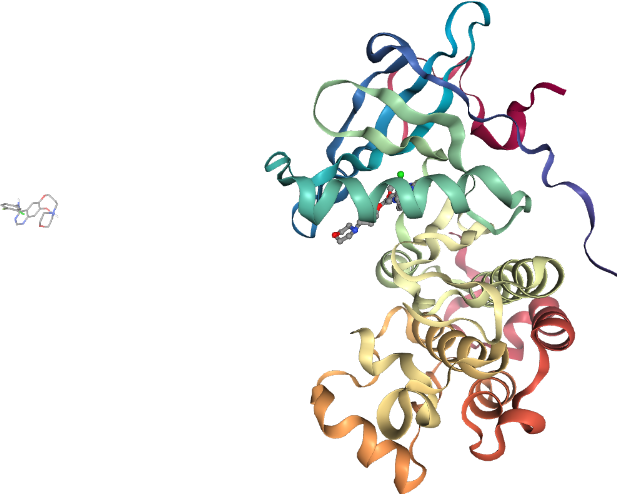

In [ ]:
view._display_image()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()